In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
import os
import seaborn as sns

from plot import plot_cluster_values, plot_decision_regions
from regression import LinearRegressionGD

c:\Users\CEDS\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
np.set_printoptions(precision=10, suppress=True)

In [3]:
def estandarizar(ex):
    return (ex - ex.mean() / ex.std())

def normalizar(ex):
    return (ex - ex.min()) / (ex.max() - ex.min())

# Cargar Datos

In [4]:
#################
### CARGAR DATOS
#################

datos = pd.read_csv('datos.csv')
# aceites = pd.read_csv('aceites.csv', encoding="latin-1")

completos = datos.dropna()

# Todas las composiciones
t_comp = datos.iloc[:, 2:5].copy()
# Todos los espectros
t_esp = datos.iloc[:, 5:].copy()

# Todos los espectros normalizados
t_espe_norm = normalizar(datos.iloc[:, 5:].copy())

# Composiciones completas normalizadas
c_comp_norm = normalizar(completos.iloc[:, 2:5].copy())
# Espectros completos normalizados
c_espe_norm = t_espe_norm[t_espe_norm.index.isin(c_comp_norm.index)].copy()

# Espectros incompletos normalizados
i_esp_norm = normalizar(datos[datos['C/G'].isna()].iloc[:, 5:].copy())

In [5]:
#################################################
# CREAR MODELO DE REGRESION, ENTRENAR Y PREDECIR
#################################################

# Espectros completos normalizados
X = c_espe_norm.values
# Composiciones completas normalizadas
y = c_comp_norm

pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(t_espe_norm)

cov_mat = np.cov(X_train_pca.T)
eig_vals, eig_vecs = np.linalg.eig(cov_mat)

class WrapperModelo():
    # Crear constructor
    def __init__(self, nombre, model):
        self.nombre = nombre
        self.model = model

    def fit(self, X, y):
        self.model.fit(X, y)

    def predict(self, X):
        return self.model.predict(X)

    def ejecutar(self):
        if os.path.exists(f'output/{self.nombre}') is False:
            os.makedirs(f'output/{self.nombre}')
        # Obtener una estimacion utilizando todos los espectros normalizados
        self.estimaciones = pd.DataFrame(columns=["est_C/G", "est_G/N", "est_P/G"], data=self.predict(t_espe_norm))
        self.estimaciones.insert(loc=0, column="WL", value=datos["WL"])
        
        #############################################
        ### REEMPLAZAR VALORES EN LA MATRIZ ORIGINAL
        #############################################
        self.combinado = datos.copy()
        self.indices_vacios = self.combinado[self.combinado["C/G"].isna()].index
        self.combinado['STATE'] = 'original'
        self.combinado.loc[self.combinado["C/G"].isna(), 'STATE'] = 'estimacion'
        self.combinado.loc[self.combinado["C/G"].isna(), 'C/G'] = self.estimaciones.values[:, 1][self.indices_vacios]
        self.combinado.loc[self.combinado["G/N"].isna(), 'G/N'] = self.estimaciones.values[:, 2][self.indices_vacios]
        self.combinado.loc[self.combinado["P/G"].isna(), 'P/G'] = self.estimaciones.values[:, 3][self.indices_vacios]
        self.combinado = self.combinado[["WL", "STATE", "C/G", "G/N", "P/G"]]
        print(self.combinado)

    def guardar(self):
        self.estimaciones.to_csv(f'output/{self.nombre}/estimaciones.csv', index=False)
        self.combinado.to_csv(f'output/{self.nombre}/combinado.csv', index=False)

    def graficar(self):
        #############
        ### GRAFICAR
        #############
        # Graficar X = G/N, Y = C/G, color = STATE
        plt.scatter(
            self.combinado[self.combinado["STATE"] == 'original']['G/N'],
            self.combinado[self.combinado["STATE"] == "original"]["P/G"],
            c='blue',
        )
        plt.scatter(
            self.combinado[self.combinado["STATE"] == 'estimacion']['G/N'],
            self.combinado[self.combinado["STATE"] == "estimacion"]["P/G"],
            c='red',
        )
        plt.xlabel('G/N')
        plt.ylabel('P/G')
        plt.show()

In [6]:
modelos = {
    "linear": LinearRegression(),
    # 'ridge': (),
    # "lasso": Lasso(alpha=0.1),
}


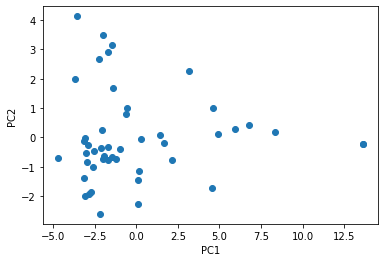

In [7]:
# Todos los espectros normalizados
# Xc = t_espe_norm.values
Xc = X_train_pca

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.scatter(Xc[:, 0], Xc[:, 1])
plt.show()

In [8]:
n_clusters=6
colors = ['blue', 'red', 'green', 'yellow', 'pink', 'orange', 'purple', 'brown', 'black']
#KMeans
km = KMeans(n_clusters=n_clusters, random_state=0)
km.fit(Xc)
kmResult = km.predict(Xc)
labels = km.labels_

esp_clasificados = t_espe_norm.copy()
esp_clasificados = esp_clasificados.assign(TYPE=labels)

In [9]:
def graficar_modelo_clasificado(modelo):
    plt.suptitle("Estimación de las composiciones clasificadas")
    for color, type in zip(colors, range(n_clusters)):
        found = modelo.combinado[modelo.combinado["TYPE"] == type]
        plt.scatter(
            found['G/N'],
            found["P/G"],
            # c=color,
            label=f"Cluster {type}"
        )
    plt.legend()
    plt.xlabel('G/N')
    plt.ylabel('P/G')
    plt.show()

           WL       STATE       C/G       G/N       P/G
0   AGUACLARA    original       0.0     1.068    0.0398
1     AGUAL02    original       0.0    0.8207    0.6335
2       ARCHT    original    0.0001    1.1932    0.4353
3        ASUS  estimacion  0.203844  0.678742  0.623404
4      BALREP    original       0.0    1.0621    0.0297
5        BASE  estimacion -0.263791  0.520911  0.249146
6          BB  estimacion  0.056896  0.909917  0.414655
7       CAT01    original       0.0    0.7846     0.193
8       CAT02    original       0.0    0.8006    0.4708
9       CHANK  estimacion -0.405505  0.844392  0.258763
10        CHE  estimacion  0.146723  0.506857  0.203873
11        CHP  estimacion -0.098476  0.434653  0.606964
12         CI  estimacion  0.212348    0.8941  0.141853
13    CTRON01    original       0.0    0.8397    0.5696
14    CTRON02    original       0.0    0.8368    0.4346
15         GP  estimacion  0.217023  0.663104  0.102963
16      HLSJP  estimacion -0.151816  0.390326  0

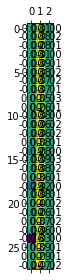

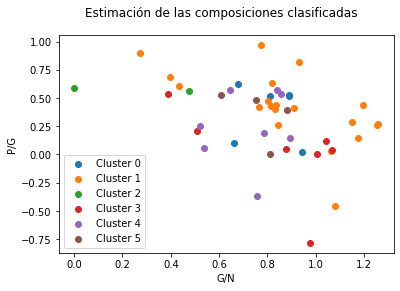

In [10]:
for m in modelos:
    modelo = WrapperModelo(m, modelos[m])
    # Entrenar unicamente utilizando los espectros normalizados (x) y composiciones normalizadas (y) completos
    modelo.fit(X, y.values)
    modelo.ejecutar()
    modelo.estimaciones.insert(loc=1, column="TYPE", value=kmResult)
    modelo.combinado.insert(loc=1, column="TYPE", value=kmResult)
    # modelo.estimaciones.assign(TYPE=kmResult)
    modelo.guardar()
    error = (modelo.combinado.values[c_comp_norm.index][:, 3:6] - modelo.estimaciones.values[c_comp_norm.index][:, 2:5]).astype(float)
    print(error)

    fig, ax = plt.subplots()
    ax.matshow(error)
    for (i, j), z in np.ndenumerate(error):
        ax.text(j, i, '{:0.2f}'.format(z), ha='center', va='center')
    plt.tight_layout()
    plt.show()
    # plt.plot(range(1,modelo.model.n_inter+1), modelo.model.cost_)
    # plt.show()
    # modelo.graficar()
    graficar_modelo_clasificado(modelo)

In [11]:
esp_clasificados = esp_clasificados.assign(ACEITE=datos["WL"])
esp_clasificados.insert(0, "ACEITE", esp_clasificados.pop('ACEITE'))
esp_clasificados.insert(1, "TYPE", esp_clasificados.pop('TYPE'))

cols = [float(x) for x in t_espe_norm.columns]

C:\Users\CEDS\AppData\Local\Temp/ipykernel_28604/4139764099.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  zipped = np.asarray([x for x in list(zip(kmResult, Xc))])


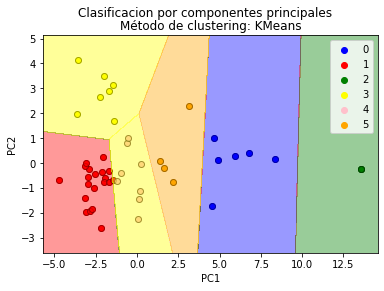

In [12]:
plt.suptitle('Clasificacion por componentes principales')
plt.title('Método de clustering: KMeans')
plt.xlabel('PC1')
plt.ylabel('PC2')
zipped = np.asarray([x for x in list(zip(kmResult, Xc))])
for label in np.sort(np.unique(labels)):
    coords = np.array([i[1] for i in zipped if i[0] == label])
    plt.scatter(coords[:, 0], coords[:, 1], c=colors[label], label=label)

for i in range(len(km.cluster_centers_)):
    centroid = km.cluster_centers_[i]

plt.legend(loc='upper right')
plot_decision_regions(Xc, labels, classifier=km)

plt.show()

In [13]:
figsize_orig = plt.rcParams['figure.figsize']

figsize_orig

[6.0, 4.0]

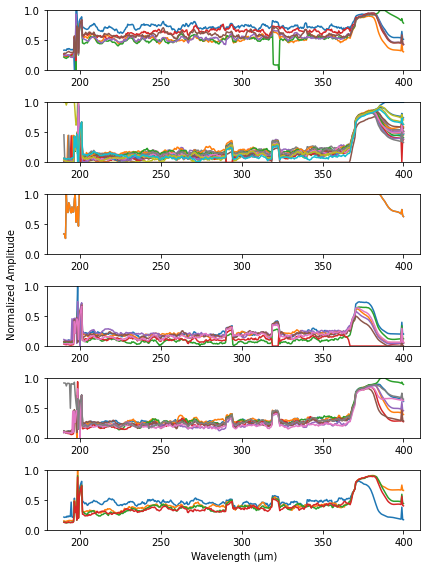

In [14]:
plt.rcParams['figure.figsize'] = [3*2, 4*2]

fig, axs = plt.subplots(n_clusters)

esp_clasificados.to_csv("clasificados.csv")

for color, type in zip(colors, range(n_clusters)):
    # rows = esp_clasificados[esp_clasificados["TYPE"] == type].loc[:, esp_clasificados.columns != 'TYPE']
    rows = esp_clasificados[esp_clasificados["TYPE"] == type].iloc[:, 2:]
    # axs[type].set_title(f'Cluster {type} ({len(rows)} essential oils)')
    # axs[type].set(xlabel='Wavelength', ylabel='Normalized\nAmplitude')
    # Set y lim
    axs[type].set_ylim(0, 1)
    for index, row in rows.iterrows():
        axs[type].plot(
            cols,
            row,
            label=datos['WL'][index],
            # color=color
        )
fig.text(0.03, 0.5, 'Normalized Amplitude', ha='center', va='center', rotation='vertical')
plt.xlabel(u"Wavelength (\u03bcm)")
plt.ylabel(" ", loc='top')
plt.subplots_adjust(
    top=0.96,
    bottom=0.06,
    left=0.125,
    right=0.9,
    hspace=0.89,
    wspace=0.2
)
plt.tight_layout()
plt.savefig('prueba.png', dpi=300)
plt.show()

In [15]:
dummies = pd.get_dummies(datos.iloc[:, 1:])
new_cols = [*dummies.columns[:3], *dummies.columns[-6:], *dummies.columns[3:-6]]

df = dummies[new_cols]


In [16]:
def nice_number(i):
    return '%.1f' % i if i - int(i) != 0 else '%d' % i

In [17]:
nice_number(100.5)

'100.5'

In [18]:
cols = [nice_number(x) for x in np.arange(190, 400.5, 0.5)]
cols.reverse()

cols

['400',
 '399.5',
 '399',
 '398.5',
 '398',
 '397.5',
 '397',
 '396.5',
 '396',
 '395.5',
 '395',
 '394.5',
 '394',
 '393.5',
 '393',
 '392.5',
 '392',
 '391.5',
 '391',
 '390.5',
 '390',
 '389.5',
 '389',
 '388.5',
 '388',
 '387.5',
 '387',
 '386.5',
 '386',
 '385.5',
 '385',
 '384.5',
 '384',
 '383.5',
 '383',
 '382.5',
 '382',
 '381.5',
 '381',
 '380.5',
 '380',
 '379.5',
 '379',
 '378.5',
 '378',
 '377.5',
 '377',
 '376.5',
 '376',
 '375.5',
 '375',
 '374.5',
 '374',
 '373.5',
 '373',
 '372.5',
 '372',
 '371.5',
 '371',
 '370.5',
 '370',
 '369.5',
 '369',
 '368.5',
 '368',
 '367.5',
 '367',
 '366.5',
 '366',
 '365.5',
 '365',
 '364.5',
 '364',
 '363.5',
 '363',
 '362.5',
 '362',
 '361.5',
 '361',
 '360.5',
 '360',
 '359.5',
 '359',
 '358.5',
 '358',
 '357.5',
 '357',
 '356.5',
 '356',
 '355.5',
 '355',
 '354.5',
 '354',
 '353.5',
 '353',
 '352.5',
 '352',
 '351.5',
 '351',
 '350.5',
 '350',
 '349.5',
 '349',
 '348.5',
 '348',
 '347.5',
 '347',
 '346.5',
 '346',
 '345.5',
 '345',
 '

In [19]:
df

,C/G,G/N,P/G,TYPE_a,TYPE_b,TYPE_c,TYPE_d,TYPE_e,TYPE_f,400,...,194.5,194,193.5,193,192.5,192,191.5,191,190.5,190
0,0.0000,1.0680,0.0398,0,0,1,0,0,0,0.038911,...,-0.031470,-0.032718,-0.031738,-0.031211,-0.033137,-0.034025,-0.035131,-0.038121,-0.038988,-0.039591
1,0.0000,0.8207,0.6335,0,0,0,1,0,0,0.091295,...,-0.038201,-0.038967,-0.038387,-0.038184,-0.039430,-0.039324,-0.040177,-0.042767,-0.042756,-0.043169
2,0.0001,1.1932,0.4353,0,1,0,0,0,0,0.055657,...,-0.035908,-0.036677,-0.036339,-0.036238,-0.003810,-0.038744,-0.039666,-0.041618,-0.041893,-0.042257
3,NaN,NaN,NaN,1,0,0,0,0,0,0.059881,...,-0.011623,-0.011494,-0.010422,-0.010354,-0.011640,-0.011216,-0.012399,-0.014607,-0.014871,-0.015332
4,0.0000,1.0621,0.0297,1,0,0,0,0,0,0.057428,...,-0.038808,-0.039660,-0.039182,-0.038191,-0.040188,-0.040158,-0.041435,-0.043226,-0.043769,-0.044302
5,NaN,NaN,NaN,0,0,0,1,0,0,0.065730,...,-0.030065,-0.030913,-0.030427,-0.030065,-0.031735,-0.032500,-0.034374,-0.035994,-0.036041,-0.035945
6,NaN,NaN,NaN,1,0,0,0,0,0,0.059393,...,-0.038590,-0.039290,-0.039085,-0.039217,-0.040947,-0.041169,-0.042409,-0.045475,-0.046121,-0.046857
7,0.0000,0.7846,0.1930,1,0,0,0,0,0,0.051442,...,-0.031851,-0.032031,-0.031328,-0.031234,-0.032842,-0.032777,-0.033630,-0.035894,-0.036379,-0.036836
8,0.0000,0.8006,0.4708,1,0,0,0,0,0,0.056960,...,-0.038324,-0.039388,-0.039289,-0.038897,-0.040833,-0.040995,-0.041835,-0.044519,-0.045283,-0.045702
9,NaN,NaN,NaN,1,0,0,0,0,0,0.059933,...,-0.037781,-0.038929,-0.038568,-0.038826,-0.040436,-0.041401,-0.042255,-0.044495,-0.044752,-0.044374


In [20]:
sns.set_style("whitegrid", {'axes.grid' : False})

In [21]:
# subset = df.iloc[:, -20:-14]
# subset = df.iloc[:, -24:-10]
# subset = df.iloc[:, 9:20]
# subset = df.iloc[:, 40:50]
subset = df.iloc[:, 9:]
nums_col = subset.columns
comp_col = ['C/G', 'G/N', 'P/G']


subset = df[[*comp_col, *nums_col]].dropna()
col = subset.columns
subset.head()

,C/G,G/N,P/G,400,399.5,399,398.5,398,397.5,397,...,194.5,194,193.5,193,192.5,192,191.5,191,190.5,190
0,0.0000,1.0680,0.0398,0.038911,0.040531,0.042010,0.043341,0.044509,0.045531,0.046428,...,-0.031470,-0.032718,-0.031738,-0.031211,-0.033137,-0.034025,-0.035131,-0.038121,-0.038988,-0.039591
1,0.0000,0.8207,0.6335,0.091295,0.094527,0.097521,0.100251,0.102680,0.104834,0.106739,...,-0.038201,-0.038967,-0.038387,-0.038184,-0.039430,-0.039324,-0.040177,-0.042767,-0.042756,-0.043169
2,0.0001,1.1932,0.4353,0.055657,0.058236,0.060606,0.062744,0.064628,0.066275,0.067712,...,-0.035908,-0.036677,-0.036339,-0.036238,-0.003810,-0.038744,-0.039666,-0.041618,-0.041893,-0.042257
4,0.0000,1.0621,0.0297,0.057428,0.059920,0.062179,0.064190,0.065929,0.067420,0.068688,...,-0.038808,-0.039660,-0.039182,-0.038191,-0.040188,-0.040158,-0.041435,-0.043226,-0.043769,-0.044302
7,0.0000,0.7846,0.1930,0.051442,0.054170,0.056639,0.058819,0.060681,0.062242,0.063530,...,-0.031851,-0.032031,-0.031328,-0.031234,-0.032842,-0.032777,-0.033630,-0.035894,-0.036379,-0.036836


In [22]:
subset.columns

Index(['C/G', 'G/N', 'P/G', '400', '399.5', '399', '398.5', '398', '397.5',
       '397',
       ...
       '194.5', '194', '193.5', '193', '192.5', '192', '191.5', '191', '190.5',
       '190'],
      dtype='object', length=424)

In [23]:
# sns.pairplot(subset, height=2.0, y_vars=comp_col, x_vars=nums_col)
plt.savefig("pairplot_ngp.png")
plt.show()

<Figure size 432x576 with 0 Axes>

In [24]:
c1 = subset.corr().iloc[0,3:].map(lambda v: abs(v)).T.sort_values()
c2 = subset.corr().iloc[1,3:].map(lambda v: abs(v)).T.sort_values()
c3 = subset.corr().iloc[2,3:].map(lambda v: abs(v)).T.sort_values()

print(c1.index[-1], c1[-1])
print(c2.index[-1], c2[-1])
print(c3.index[-1], c3[-1])

382 0.5427786773431006
262.5 0.6181830742872153
381.5 0.6000646608373645


In [25]:
plt.rcParams['figure.figsize']

[6.0, 8.0]

In [26]:
plt.rcParams['figure.figsize'] = [
    12.0*3,
    8.0*1
]

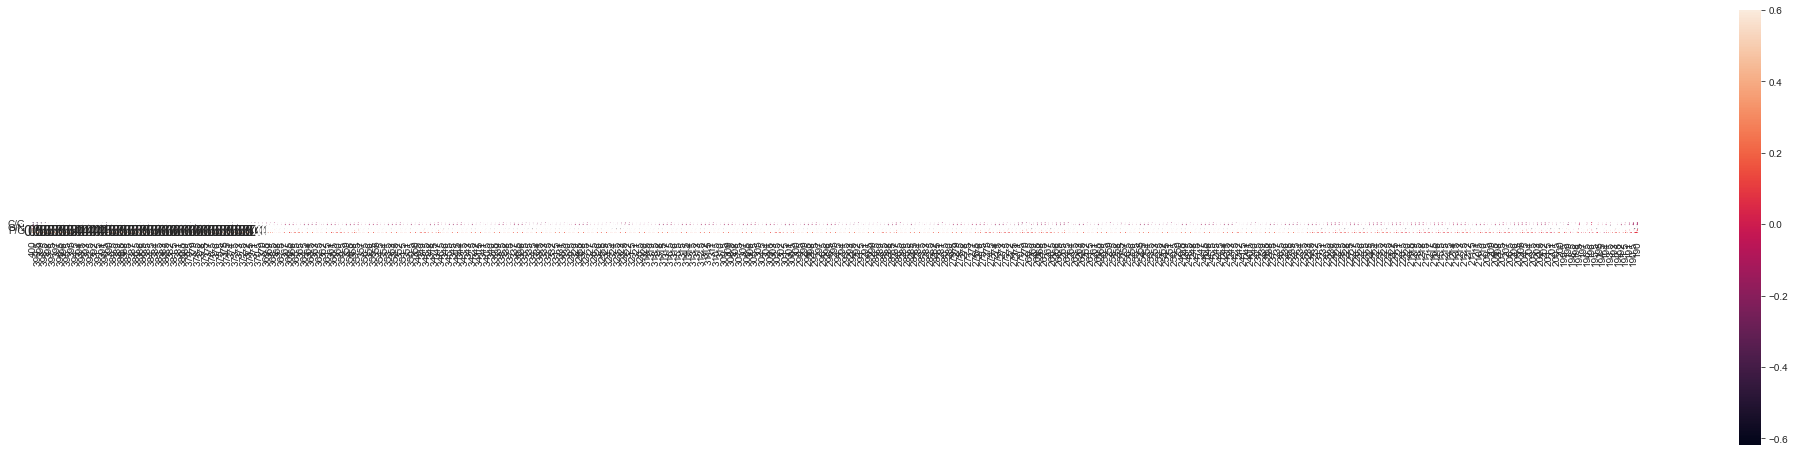

In [101]:
# cm = np.corrcoef(subset[nums_col].values.T, subset[comp_col].values.T)
# sns.set(font_scale=1.5)
hm = sns.heatmap(subset.corr().iloc[:3,3:],
    cbar=True,
    annot=True,
    square=True,
    fmt='.1f',
    annot_kws={'size': 15},
    yticklabels=['C/G', 'G/N', 'P/G'],
    # yticklabels=nums_col,
    xticklabels=nums_col
)
plt.savefig("heatmap.png")
plt.show()

In [99]:
print(c1.index[-1])
print(c2.index[-1])
print(c3.index[-1])

DF1 = df.loc[:, ["C/G", c1.index[-1]]].dropna()
DF2 = df.loc[:, ["G/N", c2.index[-1]]].dropna()
DF3 = df.loc[:, ["P/G", c3.index[-1]]].dropna()

DF1

382
262.5
381.5


,C/G,382
0,0.0000,0.242925
1,0.0000,0.294899
2,0.0001,0.288351
4,0.0000,0.288589
7,0.0000,0.295806
8,0.0000,0.293021
13,0.0000,0.282321
14,0.0000,0.294016
18,0.0000,0.286539
20,0.0000,0.292794


In [47]:
DF1.iloc[:, 1].to_numpy().reshape(-1, 1)

array([[0.242925],
       [0.294899],
       [0.288351],
       [0.288589],
       [0.295806],
       [0.293021],
       [0.282321],
       [0.294016],
       [0.286539],
       [0.292794],
       [0.23537 ],
       [0.307019],
       [0.303481],
       [0.292983],
       [0.288479],
       [0.282924],
       [0.304045],
       [0.298137],
       [0.198523],
       [0.291853],
       [0.296899],
       [0.287933],
       [0.29428 ],
       [0.186896],
       [0.210646],
       [0.281452],
       [0.293053],
       [0.314957]])

In [65]:
model1 = LinearRegression()
model2 = LinearRegression()
model3 = LinearRegression()

model1.fit(
    X=DF1.iloc[:, 1].to_numpy().reshape(-1, 1),
    y=DF1.iloc[:, 0].to_numpy().reshape(-1, 1)
)
model2.fit(
    X=DF2.iloc[:, 1].to_numpy().reshape(-1, 1),
    y=DF2.iloc[:, 0].to_numpy().reshape(-1, 1)
)
model3.fit(
    X=DF3.iloc[:, 1].to_numpy().reshape(-1, 1),
    y=DF3.iloc[:, 0].to_numpy().reshape(-1, 1)
)

LinearRegression()

In [66]:
na_df1 = df.iloc[df.index.difference(DF1.index)]
na_df2 = df.iloc[df.index.difference(DF2.index)]
na_df3 = df.iloc[df.index.difference(DF3.index)]

In [67]:
na_df1[c1.index[-1]]
na_df2[c2.index[-1]]
na_df3[c3.index[-1]]

3     0.307849
5     0.297294
6     0.292934
9     0.277320
10    0.211472
11    0.293509
12    0.299182
15    0.296788
16    0.241818
17    0.292893
19    0.304214
21    0.294319
27    0.300012
29    0.159632
37    0.315206
39    0.273138
40    0.288405
41    0.297249
45    0.289610
Name: 381.5, dtype: float64

In [94]:
na_df1

,C/G,G/N,P/G,TYPE_a,TYPE_b,TYPE_c,TYPE_d,TYPE_e,TYPE_f,400,...,194.5,194,193.5,193,192.5,192,191.5,191,190.5,190
3,NaN,NaN,NaN,1,0,0,0,0,0,0.059881,...,-0.011623,-0.011494,-0.010422,-0.010354,-0.011640,-0.011216,-0.012399,-0.014607,-0.014871,-0.015332
5,NaN,NaN,NaN,0,0,0,1,0,0,0.065730,...,-0.030065,-0.030913,-0.030427,-0.030065,-0.031735,-0.032500,-0.034374,-0.035994,-0.036041,-0.035945
6,NaN,NaN,NaN,1,0,0,0,0,0,0.059393,...,-0.038590,-0.039290,-0.039085,-0.039217,-0.040947,-0.041169,-0.042409,-0.045475,-0.046121,-0.046857
9,NaN,NaN,NaN,1,0,0,0,0,0,0.059933,...,-0.037781,-0.038929,-0.038568,-0.038826,-0.040436,-0.041401,-0.042255,-0.044495,-0.044752,-0.044374
10,NaN,NaN,NaN,0,0,1,0,0,0,0.029683,...,-0.032910,-0.033763,-0.033242,-0.032741,-0.034729,-0.034915,-0.036696,-0.039226,-0.039562,-0.040263
11,NaN,NaN,NaN,1,0,0,0,0,0,0.059401,...,-0.035331,-0.036438,-0.035882,-0.035339,-0.037206,-0.037740,-0.039181,-0.041159,-0.041530,-0.042032
12,NaN,NaN,NaN,0,0,0,1,0,0,0.084167,...,-0.031393,-0.031714,-0.031307,-0.031441,-0.033058,-0.033595,-0.034963,-0.037517,-0.037243,-0.037532
15,NaN,NaN,NaN,0,1,0,0,0,0,0.046249,...,-0.020883,-0.021423,-0.020243,-0.019289,-0.021521,-0.021524,-0.021898,-0.024087,-0.025241,-0.025309
16,NaN,NaN,NaN,0,0,0,0,0,1,0.033944,...,-0.034453,-0.035255,-0.034031,-0.034023,-0.036005,-0.036393,-0.037834,-0.040408,-0.041085,-0.041310
17,NaN,NaN,NaN,0,0,0,1,0,0,0.067452,...,0.040692,0.041394,0.040969,0.040218,0.042107,0.042567,0.043596,0.045765,0.045958,0.046550


In [95]:
# col1 = model1.predict(na_df1[c1.index[-1]].to_numpy().reshape(-1, 1))
# col2 = model2.predict(na_df2[c2.index[-1]].to_numpy().reshape(-1, 1))
# col3 = model3.predict(na_df3[c3.index[-1]].to_numpy().reshape(-1, 1))

col1 = model1.predict(df[c1.index[-1]].to_numpy().reshape(-1, 1))
col2 = model2.predict(df[c2.index[-1]].to_numpy().reshape(-1, 1))
col3 = model3.predict(df[c3.index[-1]].to_numpy().reshape(-1, 1))

In [96]:
preds = np.array([col1.flatten(), col2.flatten(), col3.flatten()]).T

preds

array([[ 0.0442672857,  0.9562264104,  0.2255566482],
       [ 0.0017486055,  0.9679704215,  0.4377422019],
       [ 0.0071053669,  0.989887176 ,  0.4140654529],
       [-0.0082973673,  0.6982793301,  0.5015700981],
       [ 0.0069106649,  1.0016473858,  0.4134440545],
       [ 0.0000682775,  0.907241735 ,  0.4499255259],
       [ 0.0039050538,  1.0119335197,  0.4285924766],
       [ 0.0010066106,  0.8664211722,  0.4493970925],
       [ 0.0032849522,  0.9320418468,  0.4304224217],
       [ 0.0171987882,  1.0596547014,  0.3521947172],
       [ 0.0773928176,  0.9527113063,  0.0300069587],
       [ 0.0033373091,  0.9608754189,  0.4314058948],
       [-0.0014958837,  0.9219176992,  0.4591633233],
       [ 0.012038365 ,  0.9020581715,  0.3971996225],
       [ 0.0024709666,  0.953083875 ,  0.4353838235],
       [ 0.0037373482,  0.8002821413,  0.4474497179],
       [ 0.052250889 ,  1.0029918726,  0.1784869387],
       [ 0.0033356729,  1.016193761 ,  0.4283918677],
       [ 0.0085877206,  0.99

In [98]:
newdf = df.copy()

# newdf.loc[df.index.difference(DF1.index), ['C/G', 'G/N', 'P/G']] = preds
newdf.loc[df.index, ['C/G', 'G/N', 'P/G']] = preds
# newdf.loc[df.index.difference(DF1.index), ['pred']] = 1
newdf.loc[df.index, ['pred']] = 1
# newdf.loc[DF1.index, ['pred']] = 0

newdf.to_csv('preds_completo.csv', index=False)

newdf

,C/G,G/N,P/G,TYPE_a,TYPE_b,TYPE_c,TYPE_d,TYPE_e,TYPE_f,400,...,194,193.5,193,192.5,192,191.5,191,190.5,190,pred
0,0.044267,0.956226,0.225557,0,0,1,0,0,0,0.038911,...,-0.032718,-0.031738,-0.031211,-0.033137,-0.034025,-0.035131,-0.038121,-0.038988,-0.039591,1.0
1,0.001749,0.967970,0.437742,0,0,0,1,0,0,0.091295,...,-0.038967,-0.038387,-0.038184,-0.039430,-0.039324,-0.040177,-0.042767,-0.042756,-0.043169,1.0
2,0.007105,0.989887,0.414065,0,1,0,0,0,0,0.055657,...,-0.036677,-0.036339,-0.036238,-0.003810,-0.038744,-0.039666,-0.041618,-0.041893,-0.042257,1.0
3,-0.008297,0.698279,0.501570,1,0,0,0,0,0,0.059881,...,-0.011494,-0.010422,-0.010354,-0.011640,-0.011216,-0.012399,-0.014607,-0.014871,-0.015332,1.0
4,0.006911,1.001647,0.413444,1,0,0,0,0,0,0.057428,...,-0.039660,-0.039182,-0.038191,-0.040188,-0.040158,-0.041435,-0.043226,-0.043769,-0.044302,1.0
5,0.000068,0.907242,0.449926,0,0,0,1,0,0,0.065730,...,-0.030913,-0.030427,-0.030065,-0.031735,-0.032500,-0.034374,-0.035994,-0.036041,-0.035945,1.0
6,0.003905,1.011934,0.428592,1,0,0,0,0,0,0.059393,...,-0.039290,-0.039085,-0.039217,-0.040947,-0.041169,-0.042409,-0.045475,-0.046121,-0.046857,1.0
7,0.001007,0.866421,0.449397,1,0,0,0,0,0,0.051442,...,-0.032031,-0.031328,-0.031234,-0.032842,-0.032777,-0.033630,-0.035894,-0.036379,-0.036836,1.0
8,0.003285,0.932042,0.430422,1,0,0,0,0,0,0.056960,...,-0.039388,-0.039289,-0.038897,-0.040833,-0.040995,-0.041835,-0.044519,-0.045283,-0.045702,1.0
9,0.017199,1.059655,0.352195,1,0,0,0,0,0,0.059933,...,-0.038929,-0.038568,-0.038826,-0.040436,-0.041401,-0.042255,-0.044495,-0.044752,-0.044374,1.0


In [105]:
df.iloc[:, 9:].corr().to_csv('corr.csv', index=False)